#  Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 

import nltk
import re
import string
import spacy
import contractions


# Carga de datos

In [3]:
# Cargar datos de Kaggle
df_fake = pd.read_csv("Datasets/Fake.csv") # Noticias falsas
df_real = pd.read_csv("Datasets/True.csv") # Noticias verdaderas

# Agregar columna de etiquetas
df_fake["label"] = 0
df_real["label"] = 1

# Subject y Data no nos interesa
df_fake.drop(["subject", "date"], axis=1, inplace=True)
df_real.drop(["subject", "date"], axis=1, inplace=True)

In [4]:
print(df_fake.shape)
df_fake.head()

(23481, 3)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [5]:
print(df_real.shape)
df_real.head()

(21417, 3)


,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [6]:
print("Porcentaje de balanceo de clases:")
print("Fake: ", df_fake.shape[0]/(df_fake.shape[0]+df_real.shape[0]))
print("Real: ", df_real.shape[0]/(df_fake.shape[0]+df_real.shape[0]))

Porcentaje de balanceo de clases:
Fake:  0.5229854336496058
Real:  0.47701456635039424


In [7]:
# Mostrar la primera noticia fake
print("Primera noticia fake:")
print("Title: ", df_fake.iloc[0]['title'])
print("Text: ", df_fake.iloc[0]['text'])

# Mostrar la primera noticia real
print("Primera noticia real:")
print("Title: ", df_real.iloc[0]['title'])
print("Text: ", df_real.iloc[0]['text'])

Primera noticia fake:
Title:   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Text:  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president se

In [8]:
# Unir ambos datasets
df = pd.concat([df_fake, df_real])

# Mezclar datos
df = df.sample(frac=1).reset_index(drop=True)

# Ver primeras filas
print(df.head())

                                               title  \
0   Four-Year-Old Dies After Finding Loaded Gun A...   
1   Anti-Trump Protestors Shut Down Major Road Le...   
2  U.S. court backs Trump in battle over interim ...   
3  Kazakhstan, Kyrgyzstan pledge to improve ties ...   
4  Brazil's Temer sent for tests, treatment for u...   

                                                text  label  
0  A four-year-old Iowa boy died as the result of...      0  
1  Protestors have peacefully shut down the main ...      0  
2  WASHINGTON (Reuters) - A U.S. District Court j...      1  
3  ALMATY (Reuters) - The leaders of Kazakhstan a...      1  
4  SAO PAULO (Reuters) - Brazilian President Mich...      1  


In [9]:
# Comprobar que los datos siguen balanceados
print(df["label"].value_counts())

0    23481
1    21417
Name: label, dtype: int64


In [10]:
# df.to_csv("Datasets/FakeAndRealNews.csv", index=False)

# Preprocesado NLP

In [11]:
df = pd.read_csv("Datasets/FakeAndRealNews.csv")

In [12]:
# Run only once to install the spaCy model
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 2.6 MB/s eta 0:00:05
     --- ------------------------------------ 1.1/12.8 MB 10.2 MB/s eta 0:00:02
     ------ --------------------------------- 2.1/12.8 MB 14.5 MB/s eta 0:00:01
     --------- ------------------------------ 3.0/12.8 MB 14.8 MB/s eta 0:00:01
     ----------- ---------------------------- 3.8/12.8 MB 16.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.8/12.8 MB 16.0 MB/s eta 0:00:01
     ----------------- ---------------------- 5.7/12.8 MB 16.5 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 16.9 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 17.3 MB/s eta 0:00:01
     -------------------------- ------------- 8.5/12.8 MB 17.6 MB/s eta 0:00:01
     ----------------------------- ---------- 9.5/12.8 MB


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guigr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La limpieza del texto se realizará mediante la siguiente función:

In [14]:
def clean_function(text):
    text = text.lower() # Convertir a minúsculas para uniformidad
    text = re.sub(r"\[.*?\]", "", text) # Quitar todo contenido entre corchetes
    text = re.sub(f"[{string.punctuation}]", "", text) # Quitar cualquier carácter de puntuación
    text = re.sub(r"[‘’“”\"\']", "", text) # Eliminar comillas raras
    text = re.sub(r"\w*\d\w*", "", text) # Quitar palabras con números
    text = re.sub(r'https://\S+|www\.\S+', '', text) # Quitar URLs
    text = contractions.fix(text) # Expandir contracciones
    text = re.sub(r"\s.\s", " ", text) # Eliminar caracteres que miden solo 1 (espacios a ambos lados)
    text = re.sub(r"\s+", " ", text).strip() # Quitar espacios en blanco adicionales
    text = " ".join([word for word in text.split() if word not in stop_words]) # Quitar stopwords
    text = " ".join([token.lemma_ for token in nlp(text)]) # Lematización
    return text

df["clean_title"] = df["title"].apply(clean_function)
df["clean_text"] = df["text"].apply(clean_function)

In [23]:
# Mostrar comparaciones de la limpieza realizada en algunas filas de texto
number_new = 25000
print(df['label'][number_new])

print(df['title'][number_new])
print(df['text'][number_new])

print(df['clean_title'][number_new])
print(df['clean_text'][number_new])


0
SHE GREW UP BELIEVING BLACKS Could Only Support Democrats…Until She Took A Job With ACORN: WATCH The INCREDIBLE Story Of A Woman Who Took On Obama’s LEFTIST MACHINE [VIDEO]
Keep your eye on Anita Moncreif If knowledge is power she is the Democrat Party s worst nightmare. When you re on the left, and all of your friends are leftists, and your parents are leftists, you don t hang around with other people, and you only get the view of folks as what you see on TV, and how they present it to you. And you guys are seen as racist, angry people. Every time they get a chance, that s the image they push out there on TV. They try to find that one crazy Tea Party person and they try to get them to say something, and they make sure they play it on all the black stations. And you see that and you say,  Okay, these people are nuts.  So I didn t expect to find any kind of support from the Right. Everything Anita Moncreif believed to be true about the Left changed when she took a job with ACORN and q

Se puede observar que hay varias filas del DataFrame que, tras la limpieza, se quedaron en blanco (por ser URLs u otra razón). Eliminaremos dichas filas vacías.

In [24]:
# Mostrar comparaciones de la limpieza realizada en algunas filas de texto
number_new = 83
print(df['label'][number_new])

print(df['title'][number_new])
print(df['text'][number_new])

print(df['clean_title'][number_new])
print(df['clean_text'][number_new])

0
LATINOS MAKE DISGUSTING VIDEOS Bashing TRUMP: “Make America Mexico Again” [Video]
 
latinos make disgusting video bash trump make america mexico



In [25]:
# Eliminar filas con texto vacío
filas_antes = df.shape[0]
df = df[df['clean_text'].str.strip() != '']
filas_despues = df.shape[0]
filas_eliminadas = filas_antes - filas_despues
print(f"Se han eliminado {filas_eliminadas} filas.")

# Mostrar las primeras filas del DataFrame después de eliminar filas vacías
df.head()

Se han eliminado 705 filas.


,title,text,label,clean_title,clean_text
0,WHATEVER HAPPENED To Trump’s Second Wife? [VIDEO],It s a pretty safe bet that the press isn t ab...,0,whatever happen trump second wife,pretty safe bet press able reveal bad blood do...
1,ABSOLUTE SUBMISSION: Trump Bows to Neocon Orth...,Consortium News Exclusive: In his Mideast trip...,0,absolute submission trump bow neocon orthodoxy,consortium news exclusive mideast trip saudi a...
2,LONDON’S MAYOR HAS HARSH WORDS For Our Communi...,Our country is spinning out of control. Obama ...,0,londons mayor harsh word community organizer c...,country spin control obama orchestrate effort ...
4,Trump's top defense and homeland officials to ...,BERLIN (Reuters) - U.S. Secretary of Defense J...,1,trump top defense homeland official attend mun...,berlin reuter us secretary defense james matti...
5,Support for Brazil's pension reform more organ...,BRASILIA/RIO DE JANEIRO (Reuters) - The govern...,1,support brazil pension reform organize lawmaker,brasiliario de janeiro reuters government braz...


In [26]:
# Comprobar que los datos siguen balanceados
print(df["label"].value_counts())

0    22777
1    21416
Name: label, dtype: int64


Guardamos en un DataFrame todos los datos por si, en un futuro, se necesita utilizarlos.

In [28]:
# Guardar el DataFrame en un archivo CSV
df.to_csv("Datasets/CleanedAllData.csv", index=False)

Guardaremos en otro DataFrame únicamente las columnas procesadas tras la limpieza.
Este DataFrame es el que se utilizará a partir de ahora.

In [29]:
# Eliminar las columnas 'title' y 'text'
df.drop(['title', 'text'], axis=1, inplace=True)

# Mostrar las primeras filas del DataFrame
df.head()

,label,clean_title,clean_text
0,0,whatever happen trump second wife,pretty safe bet press able reveal bad blood do...
1,0,absolute submission trump bow neocon orthodoxy,consortium news exclusive mideast trip saudi a...
2,0,londons mayor harsh word community organizer c...,country spin control obama orchestrate effort ...
4,1,trump top defense homeland official attend mun...,berlin reuter us secretary defense james matti...
5,1,support brazil pension reform organize lawmaker,brasiliario de janeiro reuters government braz...


In [30]:
# Guardar el DataFrame en un archivo CSV
df.to_csv("Datasets/CleanedFakeAndRealNews.csv", index=False)

# Vectorización

In [ ]:
df = pd.read_csv("Datasets/CleanedFakeAndRealNews.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos solo el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF

In [ ]:
# Definimos y utilizamos vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # 5000 palabras más importantes
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Modelos

### Random Forest

(Vectorización previa con TF-IDF)

In [ ]:
# Entrenar modelo 
rf = RandomForestClassifier(n_estimators=100) 
rf.fit(X_train, y_train) 
 
# Evaluación en test
y_pred = rf.predict(X_test) 
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.996605950899423


# Explicabilidad

### SHAP para el Random Forest

In [ ]:
import shap

# Es necesario convertir las matrices dispersas a densas
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Aplicamos SHAP
explainer = shap.Explainer(rf, X_train_dense)
shap_values = explainer(X_test_dense)

In [32]:
shap_values.shape

(8839, 5000, 2)

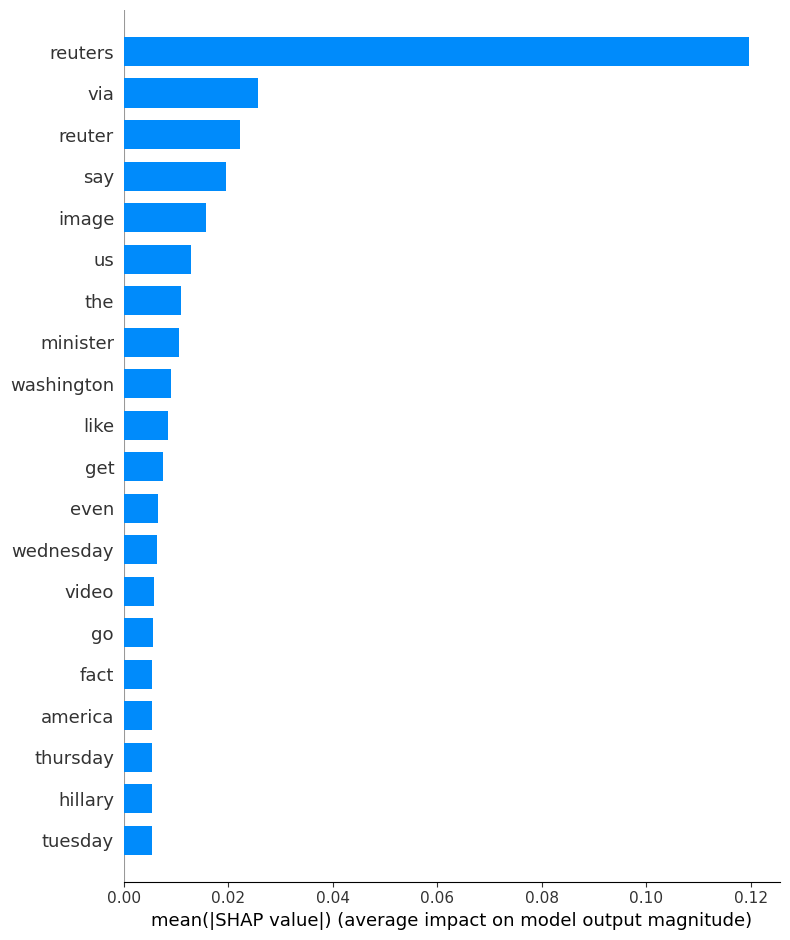

In [ ]:
# Obtén las palabras de los vectores TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Elegir índice que vas a explicar
class_index = 0 # Noticia falsa

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names, plot_type="bar")

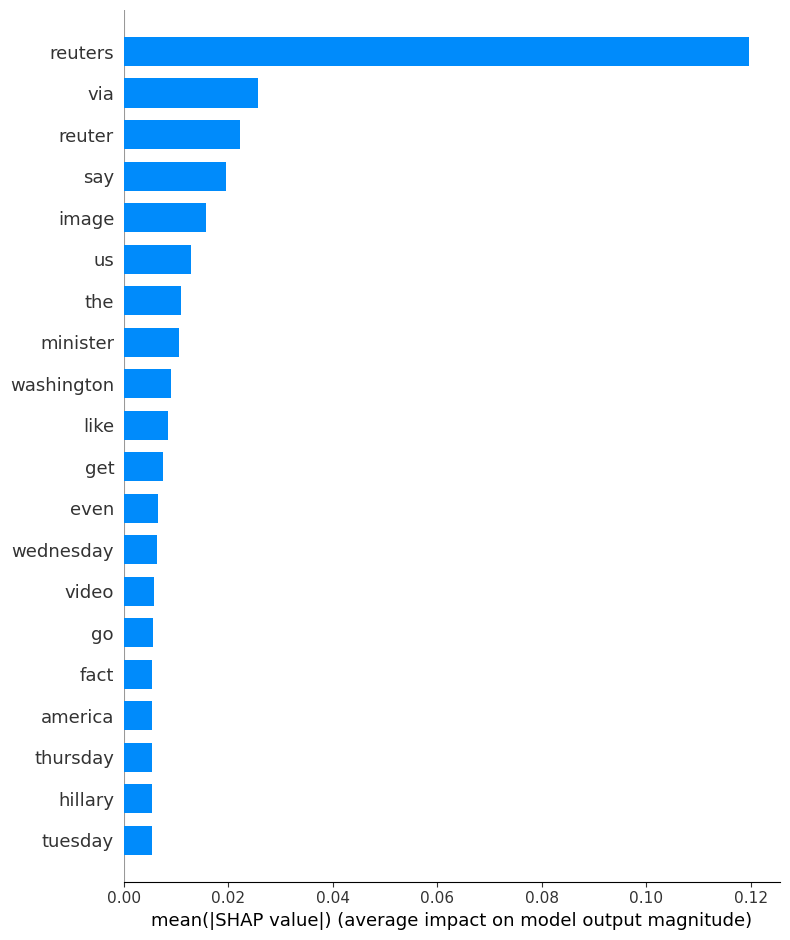

In [34]:
# Elegir índice que vas a explicar
class_index = 1 # Noticia real

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names, plot_type="bar")

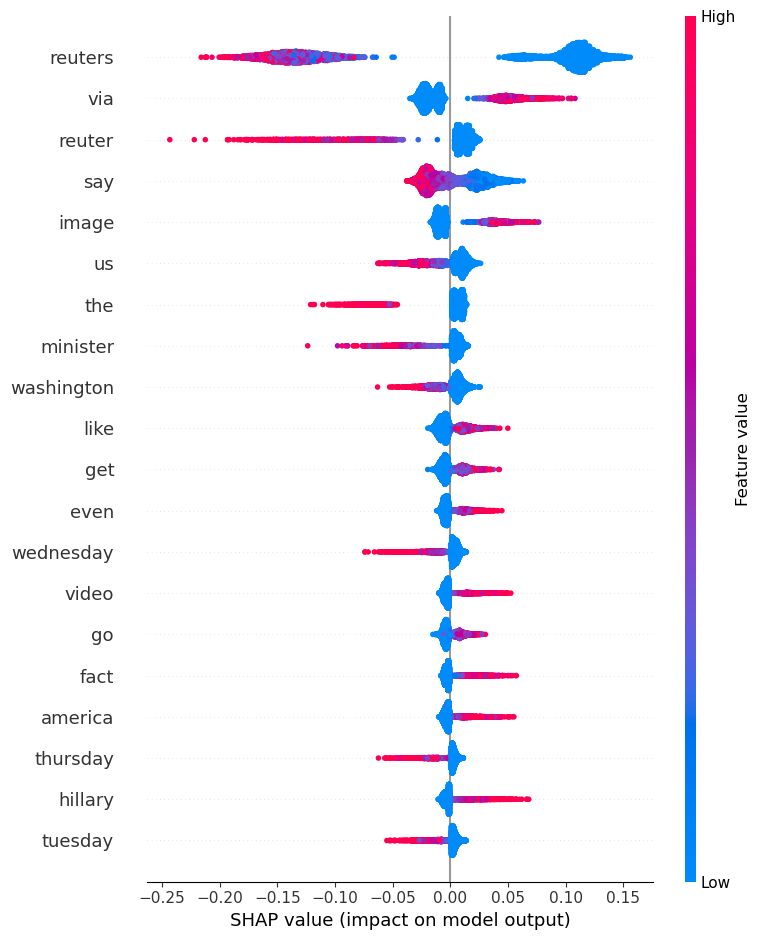

In [35]:
# Elegir índice que vas a explicar
class_index = 0 # Noticia Falsa

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names)